In [1]:
import datetime, os
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import Callback
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.cm as cm
from sklearn.metrics import classification_report, confusion_matrix

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
SEED = 548
BATCH_SIZE = 64
EPOCHS = 250
LEARNING_RATE = 0.0005
IMAGE_SIZE = 224
im_shape = (IMAGE_SIZE, IMAGE_SIZE)
data_path = "."

In [3]:
def set_seed(seed):
    tf.random.set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)

In [4]:
def plot_history_acc_loss(history):
    epochs = range(len(history.history['loss']))
    fig, ax = plt.subplots(1,2,figsize=(14,7))
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
                 fontname='monospace',color=colors_dark[0],y=1,x=0.28,alpha=0.8)

    sns.despine()
    ax[0].plot(epochs, train_acc, color=colors_green[1],
               label = 'Training Accuracy')
    ax[0].plot(epochs, val_acc, color=colors_red[1],
               label = 'Validation Accuracy')
    ax[0].legend(frameon=False)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')

    sns.despine()
    ax[1].plot(epochs, train_loss, color=colors_green[1],
               label ='Training Loss')
    ax[1].plot(epochs, val_loss, color=colors_red[1],
               label = 'Validation Loss')
    ax[1].legend(frameon=False)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Training & Validation Loss')

    fig.show()

In [5]:
def plot_history_precision_recall(history):
    epochs = range(len(history.history['loss']))
    fig, ax = plt.subplots(1,2,figsize=(14,7))
    train_acc = history.history['precision']
    train_loss = history.history['recall']
    val_acc = history.history['val_precision']
    val_loss = history.history['val_recall']

    fig.text(s='Epochs vs. Training and Validation Precision/Recall',size=18,fontweight='bold',
                 fontname='monospace',color=colors_dark[0],y=1,x=0.28,alpha=0.8)

    sns.despine()
    ax[0].plot(epochs, train_acc, color=colors_green[1],
               label = 'Training Precision')
    ax[0].plot(epochs, val_acc, color=colors_yellow[1],
               label = 'Validation Precision')
    ax[0].legend(frameon=False)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Training & Validation Precision')

    sns.despine()
    ax[1].plot(epochs, train_loss, color=colors_green[1],
               label ='Training Recall')
    ax[1].plot(epochs, val_loss, color=colors_yellow[1],
               label = 'Validation Recall')
    ax[1].legend(frameon=False)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Training & Validation Recall')

    fig.show()

In [6]:
def plot_history_accuracy_f1_score(history):
    epochs = range(len(history.history['loss']))
    
    fig, ax = plt.subplots(1,2,figsize=(14,7))
    train_acc = history.history['accuracy']
    train_loss = history.history['f1_score']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_f1_score']

    fig.text(s='Epochs vs. Training and Validation Accuracy/F1 Score',size=18,fontweight='bold',
                 fontname='monospace',color=colors_dark[0],y=1,x=0.28,alpha=0.8)

    sns.despine()
    ax[0].plot(epochs, train_acc, color=colors_blue[1],
               label = 'Training Accuracy')
    ax[0].plot(epochs, val_acc, color=colors_red[1],
               label = 'Validation Accuracy')
    ax[0].legend(frameon=False)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Training & Validation Accuracy')

    sns.despine()
    ax[1].plot(epochs, train_loss, color=colors_blue[1],
               label ='Training F1 Score')
    ax[1].plot(epochs, val_loss, color=colors_red[1],
               label = 'Validation F1 Score')
    ax[1].legend(frameon=False)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Training & Validation F1 Score')

    fig.show()

In [7]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (12, 12), fontsize=14):
    group_counts = ["{0:0.0f}".format(value) for value in
                    confusion_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         confusion_matrix.flatten() / np.sum(confusion_matrix)]

    labels = [f"{v2}\n{v3}" for v2, v3 in
              zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(len(class_names), len(class_names))

    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Note that due to returning the created figure object, when this funciton is called in a notebook
    # the figure willl be printed twice. To prevent this, either append ; to your function call, or
    # modify the function by commenting out this return expression.
    return fig

In [8]:
def get_img_array(img):
    
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [9]:
def display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4,preds=[0,0,0,0], plot=None):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image

    # Display Grad CAM
    plot.imshow(superimposed_img)
    plot.axis('off')

In [10]:
def gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output,  model.output]
    )
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
        
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [11]:
# Extracting False Negatives 
def evaluate_model(model, data, labels):
  false_predictions = []
  for img, label in zip(data, labels):
    image = image = tf.expand_dims(img, axis=0)
    predicted = model.predict(image)
    true_label= np.argmax(label)
    predicted_label = np.argmax(predicted)
    confidence = predicted[0][predicted_label]

    if true_label != predicted_label:
      false_predictions.append([img, true_label, predicted_label, confidence, predicted])
  return false_predictions

In [12]:
def sove_plots(false_predictions, model, last_conv_layer_name):
  for i, sample in enumerate(false_predictions):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 10))
    plt.subplots_adjust(bottom=0)
    img, true_label, predicted_label, trust, prediction = sample[0], sample[1], sample[2], sample[3], sample[4][0]    

    im_class = classes[true_label]
    true_label_class = r"True Label: $\bf{" + str(classes[true_label]) + "}$"
    predicted_label_class = r"Predicted Label: $\it{"+ str(classes[predicted_label]) + "}$"

    confidence = "Confidence: " + str(trust)

    img_array = get_img_array(img)
    # Remove last layer's softmax
    model.layers[-1].activation = None
    # Print what the top predicted class is
    preds = model.predict(img_array)
    title = "{} \n {} \n {} \n".format(
        true_label_class, predicted_label_class, confidence)
    plt.axis('off')
    heatmap = gradcam_heatmap(img_array, model, last_layer_name)
    heatmap = np.reshape(heatmap, (7,7))
    display_gradcam(img, heatmap, preds=preds[0], plot=ax1)
    _ = ax2.imshow(img)
    _ = ax3.imshow(heatmap)
    ax1.set_title("GradCam")
    ax2.set_title(title)
    ax3.set_title('Attention Map')
    plt.show()
    plt.close()
    print('------------')

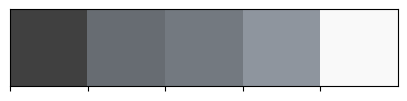

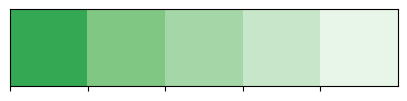

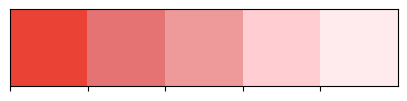

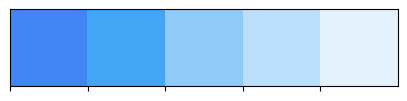

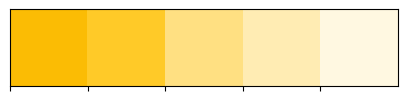

In [13]:
colors_dark = ["#404040", "#676c72", '#737980', '#8e959e', '#f9f9f9']
colors_red = ["#EA4335", "#E57373", '#EF9A9A', '#FFCDD2', '#FFEBEE']
colors_green = ['#34A853','#81C784','#A5D6A7','#C8E6C9','#E8F5E9']
colors_blue = ['#4285F4','#42A5F5','#90CAF9','#BBDEFB','#E3F2FD']
colors_yellow = ['#FBBC04','#FFCA28','#FFE082','#FFECB3','#FFF8E1']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)
sns.palplot(colors_blue)
sns.palplot(colors_yellow)

## Load & Clean

In [14]:
eda_data_gen = ImageDataGenerator(
        rescale=1./255,
)

In [15]:
eda_generator = eda_data_gen.flow_from_directory(data_path+'/Training', target_size=im_shape, class_mode='categorical', subset="training")


classes = list(eda_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 3631 images belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [16]:
data_gen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255,
        zoom_range=0.2,
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
)

test_gen = ImageDataGenerator(
        rescale=1./255,
)

In [17]:
print("Training Data:")
train_generator = data_gen.flow_from_directory(data_path + "/Training", target_size=im_shape, shuffle=True, seed=SEED,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

print("Validation Data:")
validation_generator = data_gen.flow_from_directory(data_path + "/Training", target_size=im_shape, shuffle=False, seed=SEED,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

print("Test Data:")
test_generator = test_gen.flow_from_directory(data_path + "/Testing", target_size=im_shape, shuffle=False, seed=SEED,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples

nb_test_samples = test_generator.samples

classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Training Data:
Found 2906 images belonging to 4 classes.
Validation Data:
Found 725 images belonging to 4 classes.
Test Data:
Found 1213 images belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [18]:
steps_per_epoch = nb_train_samples // BATCH_SIZE
validation_steps = nb_validation_samples // BATCH_SIZE
test_steps = nb_test_samples // BATCH_SIZE

In [19]:
# Weight Balencing
from collections import Counter
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : nb_train_samples/(num_images * num_classes) for class_id, num_images in counter.items()}

In [20]:
class_weights

{0: 1.0794947994056463,
 1: 1.131619937694704,
 2: 0.9138364779874214,
 3: 0.9126884422110553}

## Exploratory Data Analysis

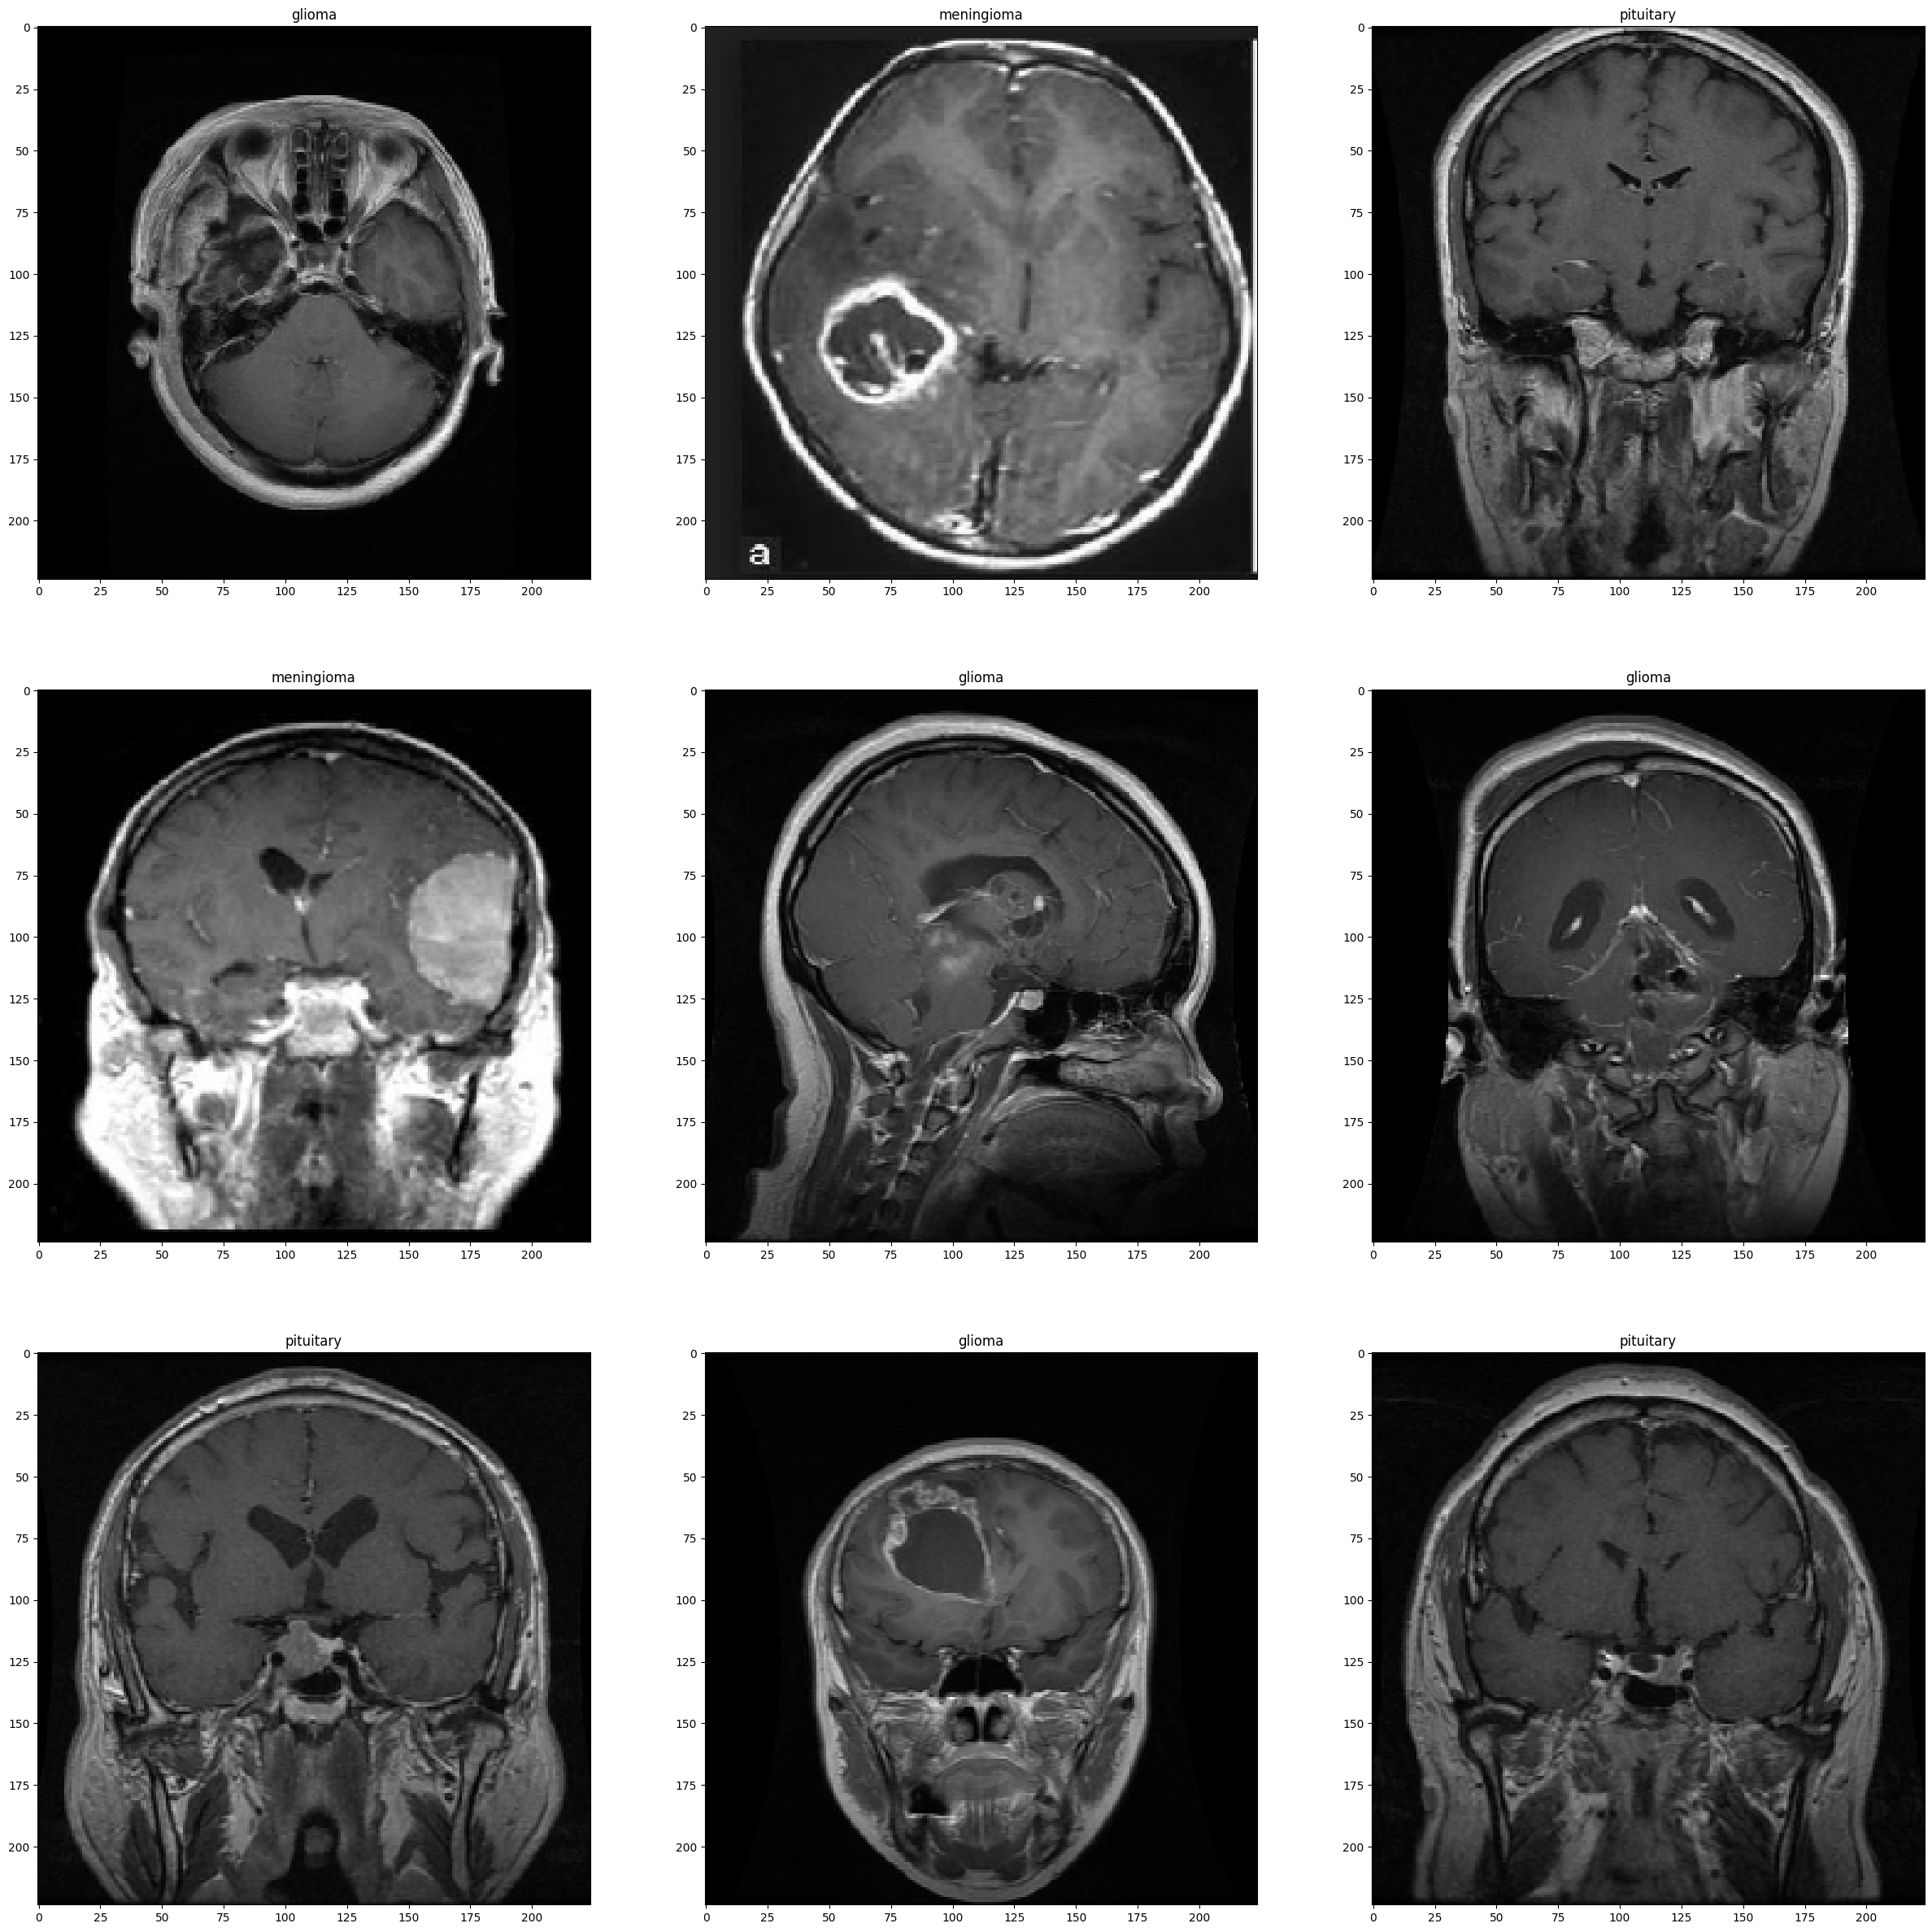

In [21]:
plt.figure(figsize=(30,30))
images = eda_generator.next()*255
for i, (image, l) in enumerate(zip(images[0][:9],images[1][:9])):
    ax = plt.subplot(330 + 1 + i)
    ax.set_title( classes[np.argmax(l)] )
    plt.imshow(image)
plt.show()

Text(0.5, 1.0, 'Pituitary Tumor')

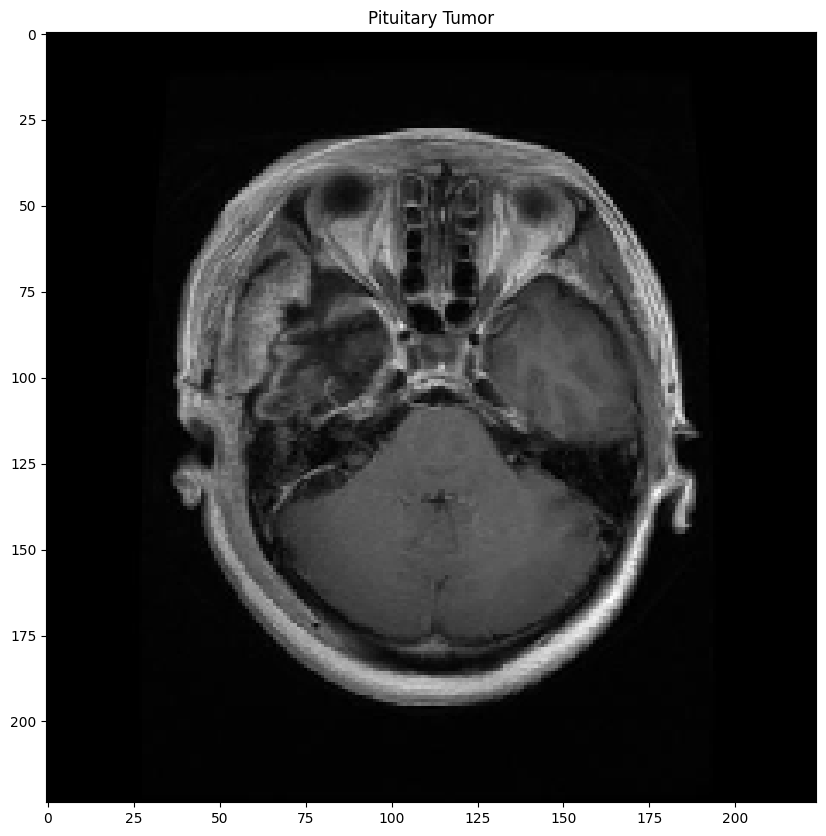

In [22]:
pituitary_tumor_sample = images[0][0]
plt.figure(figsize=(10,10))
plt.imshow(pituitary_tumor_sample)
plt.title("Pituitary Tumor")

Text(0.5, 1.0, 'Pituitary Tumor')

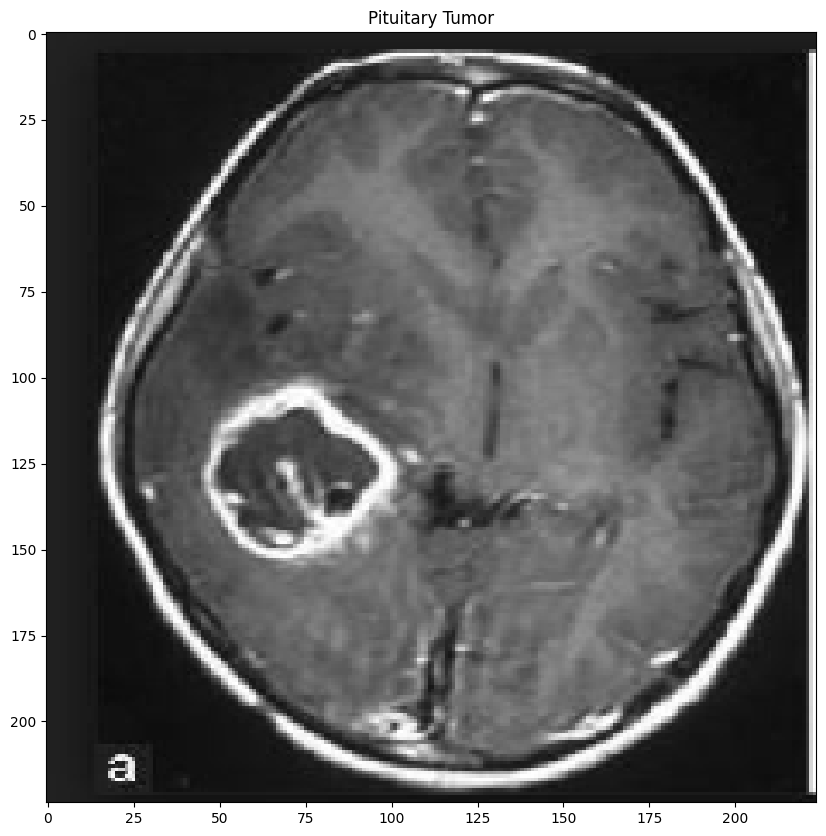

In [23]:
pituitary_tumor_sample = images[0][1]
plt.figure(figsize=(10,10))
plt.imshow(pituitary_tumor_sample)
plt.title("Pituitary Tumor")

Text(0.5, 1.0, 'Glioma Tumor')

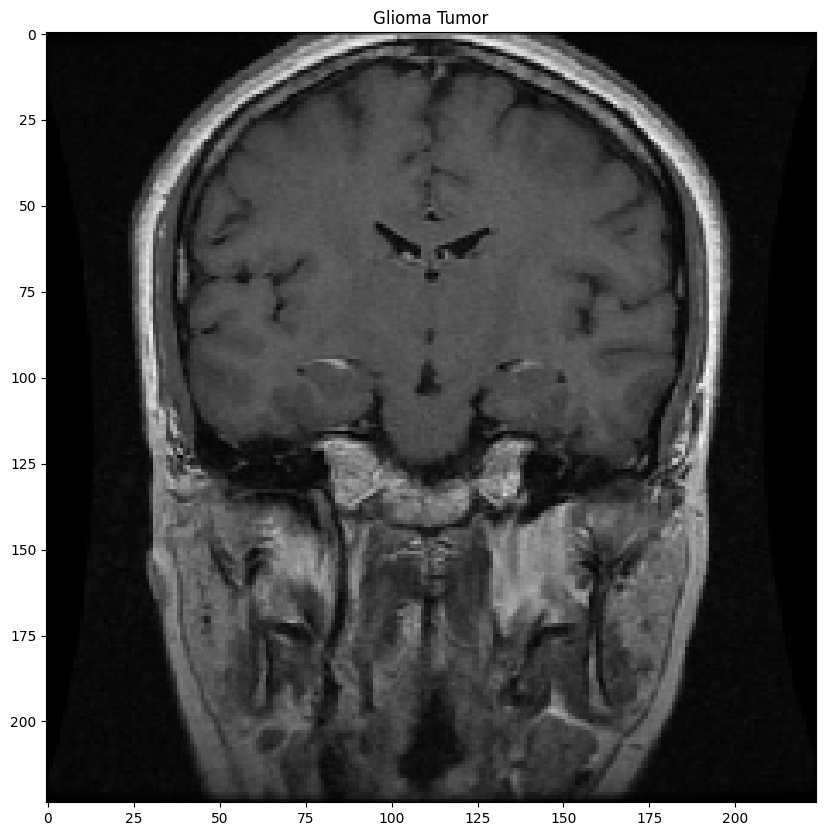

In [24]:
glioma_tumor_sample = images[0][2]
plt.figure(figsize=(10,10))
plt.imshow(glioma_tumor_sample)
plt.title("Glioma Tumor")

Text(0.5, 1.0, 'Meningioma Tumor')

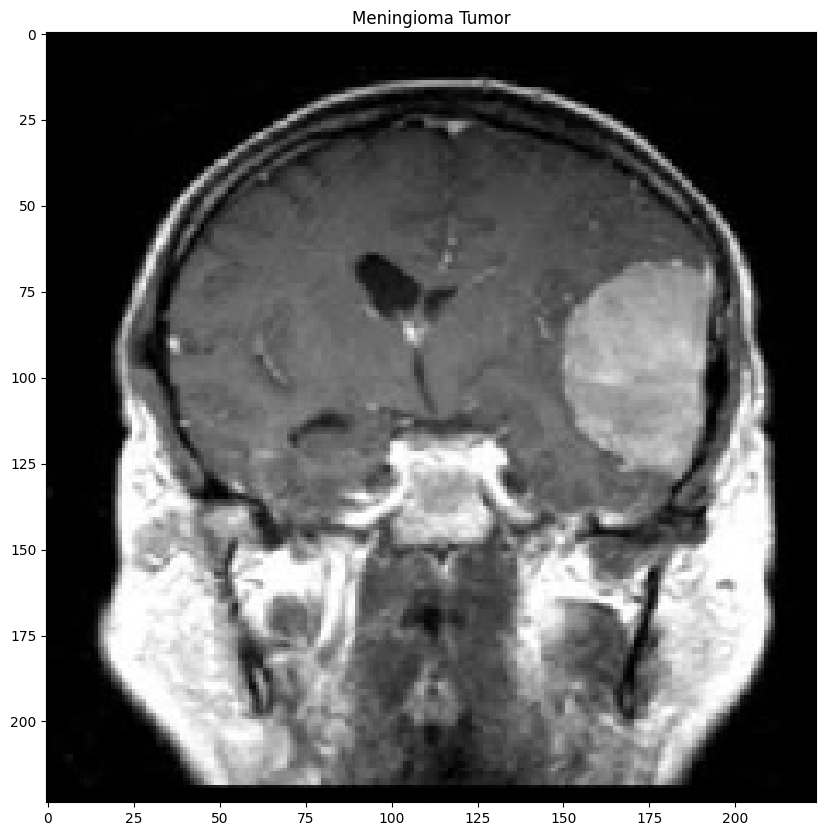

In [25]:
meningioma_tumor_sample = images[0][3]
plt.figure(figsize=(10,10))
plt.imshow(meningioma_tumor_sample)
plt.title("Meningioma Tumor")
# 75, 75

Text(0.5, 1.0, 'No Tumor')

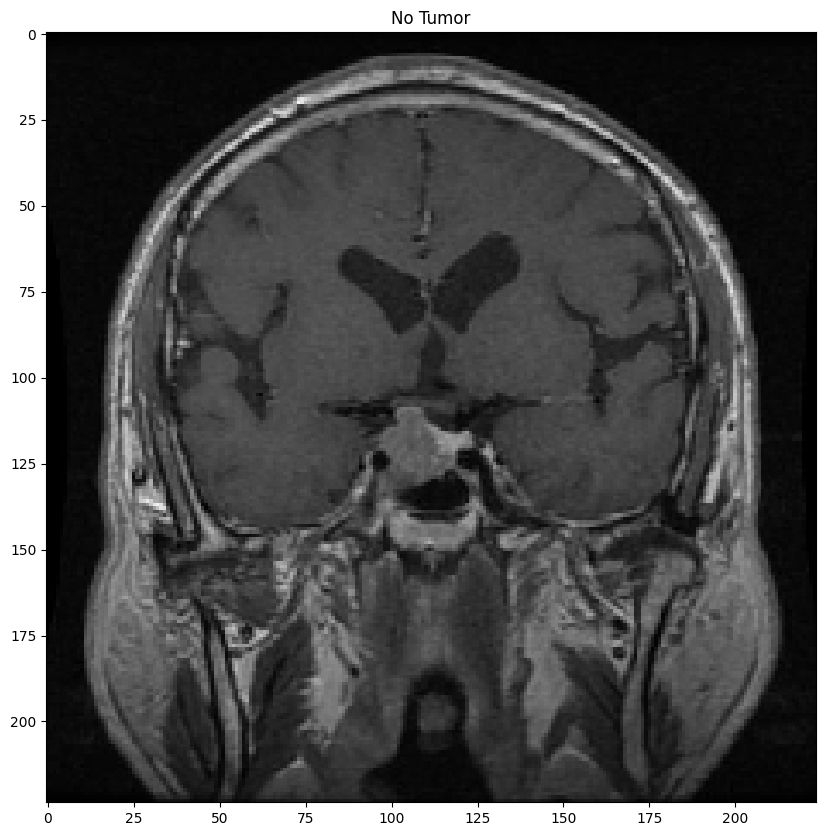

In [26]:
no_tumor_sample = images[0][6]
plt.figure(figsize=(10,10))
plt.imshow(no_tumor_sample)
plt.title("No Tumor")

### Modeling

Text(0.5, 1.0, 'No Tumor')

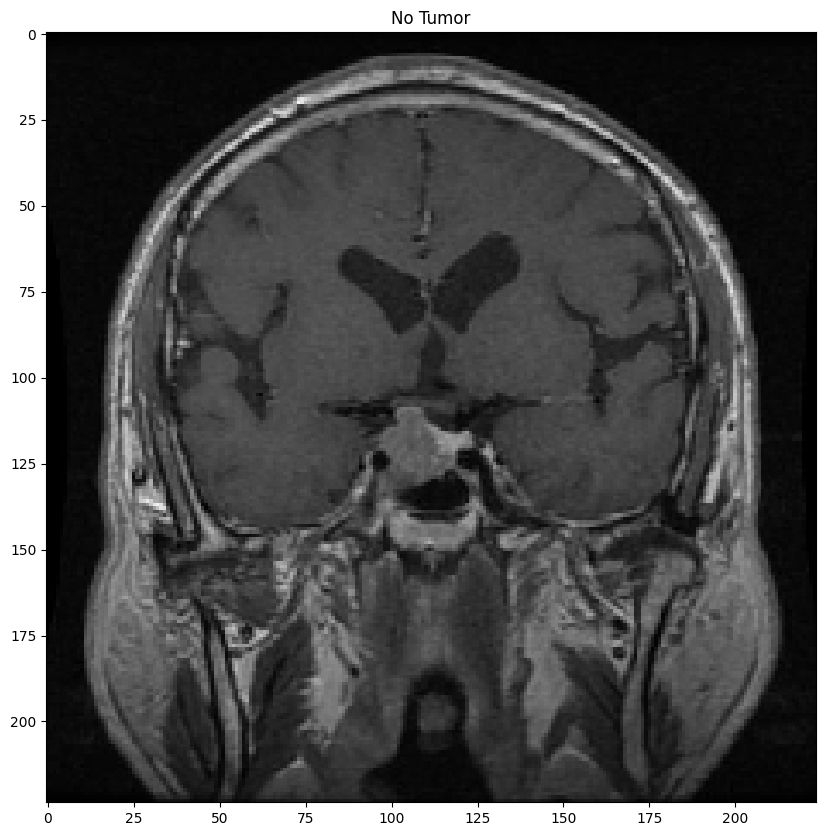

In [27]:
no_tumor_sample = images[0][6]
plt.figure(figsize=(10,10))
plt.imshow(no_tumor_sample)
plt.title("No Tumor")

In [28]:
transfer_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
for l in transfer_model.layers:
# Freezing the model
  l.trainable = False  

19993432/19993432 [==============================] - 12s 1us/step


In [29]:
model = transfer_model.output
model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.Dropout(rate=0.2)(model)
model = tf.keras.layers.Dense(16, activation='relu')(model)
model = tf.keras.layers.Dense(32, activation='relu')(model)
model = tf.keras.layers.Dense(64, activation='relu')(model)
model = tf.keras.layers.Dense(32, activation='relu')(model)
model = tf.keras.layers.Dense(16, activation='relu')(model)
model = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer='l1_l2')(model)
model = tf.keras.models.Model(inputs=transfer_model.input, outputs = model)

In [30]:
opt = tf.keras.optimizers.Adam(learning_rate= LEARNING_RATE,     amsgrad=True)
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=num_classes, threshold=0.5)]

In [31]:
model.compile(loss='categorical_crossentropy',optimizer = opt, metrics= metrics)

In [32]:
checkpoint = ModelCheckpoint("check_model.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [33]:
callbacks = [checkpoint, early_stopping]

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 32)         128       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['stem_bn1[0][0]']        

In [35]:
history = model.fit(
      train_generator,
      callbacks=callbacks,
      steps_per_epoch = steps_per_epoch,
      epochs = EPOCHS,
      validation_data = validation_generator,
      verbose = 1,
      validation_steps = validation_steps,
      class_weight=class_weights
    )

Epoch 1/250
28/45 [=================>............] - ETA: 2:56 - loss: 1.3535 - accuracy: 0.4531 - precision: 0.8195 - recall: 0.2204 - f1_score: 0.2504

### Evaluation

In [ ]:
plot_history_acc_loss(history)

In [ ]:
plot_history_precision_recall(history)

In [ ]:
model.load_weights('check_model.h5')

In [ ]:
model.evaluate(test_generator)

In [ ]:
test_data, test_labels = zip(*(test_generator[i] for i in range(test_steps)))
test_data, test_labels = np.vstack(test_data), np.vstack(test_labels)

In [ ]:
test_predictions = model.predict(test_data)
ground_truth_class_ids = test_labels.argmax(axis=1)

# take the argmax for each set of prediction scores
# to return the class id of the highest confidence prediction
top_pred_ids = test_predictions.argmax(axis=1)
conf_mat = confusion_matrix(ground_truth_class_ids, top_pred_ids)
figure = print_confusion_matrix(conf_mat, classes)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
false_predictions = evaluate_model(model, test_data, test_labels)

In [ ]:
print(len(false_predictions))

In [ ]:
last_layer_name = 'activation_187'

In [ ]:
sove_plots(false_predictions, model, last_layer_name)